In [1]:
### IMPORTANT: RESTART KERNEL AFTER UPDATING THE MODEL TO INVOKE CHANGES! ### 
%matplotlib inline
from model import *
from plotting import *
from analysis import *
import pickle

print_model = True
print_analysis = True

In [2]:
settings = [
#     X   I     N   C            W
    [ 4,  5, 10, "A", [0.3, 0.3, 0.2, 0.2]],
    [ 4, 10, 10, "A", [0.3, 0.3, 0.2, 0.2]],
    [ 4, 20, 10, "A", [0.3, 0.3, 0.2, 0.2]],
    [ 4,  5, 10, "B", [0.4, 0.4, 0.1, 0.1]],
    [ 4, 10, 10, "B", [0.4, 0.4, 0.1, 0.1]],
    [ 4, 20, 10, "B", [0.4, 0.4, 0.1, 0.1]],
    [ 6,  5, 10, "A", [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]],
    [ 6, 10, 10, "A", [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]],
    [ 6, 20, 10, "A", [0.2, 0.2, 0.2, 0.2, 0.1, 0.1]],
    [ 6,  5, 10, "B", [0.3, 0.3, 0.1, 0.1, 0.1, 0.1]],
    [ 6, 10, 10, "B", [0.3, 0.3, 0.1, 0.1, 0.1, 0.1]],
    [ 6, 20, 10, "B", [0.3, 0.3, 0.1, 0.1, 0.1, 0.1]],
    [10,  5, 10, "A", [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05]],
    [10, 10, 10, "A", [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05]],
    [10, 20, 10, "A", [0.2, 0.2, 0.1, 0.1, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05]],
    [10,  5, 10, "B", [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]],
    [10, 10, 10, "B", [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]],
    [10, 20, 10, "B", [0.3, 0.2, 0.1, 0.1, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05]], 
]

In [3]:
# E = 0: no breaking points
# E = 1: one random breaking point for the first party
# E = 2: one breaking point on the top issue of the first party
# E = 3: two conflicting breaking points
# E = 4: one random breaking point per party
# E = 5: one top issue breaking point per party
# E = 6: two random breaking points per party
# E = 7: two top issue breaking points per party
# E = 8: one breaking point on the top issue of the first party + vote revaluation
# E = 9: one breaking point on a random issue of the last party
# E = 10: one breaking point on the top issue of the last party

for setting in settings[:3]:   
    grid_results = []
    X, I, N, C, poll_results = setting
    print("X = {}, N = {}, I = {}, C = {}".format(X, N, I, C))
    
    for i in range(1):             
        agendas = generate_agendas(I, X)
        supporters = generate_relative_profile(N, agendas, poll_results)
        
        supporter_IDs = [None] * X
        first_ID = 0
        for i, x_supp in supporters:
            IDs = [first_ID + i for i in range(len(x_supp))]
            supporter_IDs[i] = IDs
            first_ID += len(x_supp)
            
        no_supporters = [len(x_supp) for x_supp in supporters]
        
        profile = [item for sublist in supporters for item in sublist]
        
        print("Supporters: {}\nSupporter IDs:{}\nNumber of supporters:{}\nProfile: {}".format(supporters, supporter_IDs, no_supporters, profile) )    
        
        vote_results, vote_supporters = simulate_vote(agendas, profile, 1)
        median_voter = np.median(profile, axis=0)
        
        print("Median voter: ", median_voter)
        
        gold_regret = np.mean(calculate_regret(median_voter, profile, 1))
        
        no_supporters = [len(x_supp) for x_supp in supporters]
            
        for E in range(11):     

            if E == 0: 
                breaking_points = generate_breakingpoints(X, I, 0)
            elif E == 1 or E == 4 or E == 9: 
                breaking_points = generate_breakingpoints(X, I, 1)
            elif E == 2 or E == 8:                 
                breaking_points = derive_breaking_points(1, supporters, agendas, True)
            elif E == 3: 
                breaking_points = derive_breaking_points(2, supporters, agendas, True)
            elif E == 5 or E == 10:
                breaking_points = derive_breaking_points(1, supporters, agendas, False)
            elif E == 6:
                breaking_points = generate_breakingpoints(X, I, 2)
            elif E == 7: 
                breaking_points = derive_breaking_points(2, supporters, agendas, False)
                     
            if E == 1 or E == 2:
                breaking_points_one = [None] * X
                breaking_points_one[0] = breaking_points[0]
                breaking_points = breaking_points_one
                
            if E == 9 or E == 10:
                breaking_points_one = [None] * X
                breaking_points_one[-1] = breaking_points[-1]
                breaking_points = breaking_points_one
                
            if E == 8:
                vote_results = revaluate_votes(agendas, profile, vote_supporters, vote_results, breaking_points)

            possible_coalitions = generate_coalitions(vote_results, agendas, breaking_points)
            if len(possible_coalitions) == 0:
                grid_results.append([0, 0, 0, gold_regret])
                continue   

            expected_outcomes = simulate_outcomes(vote_results, possible_coalitions, agendas, breaking_points)
            ratings = rate_coalitions(possible_coalitions, agendas, vote_results, expected_outcomes, breaking_points)
            final_expected_outcomes = np.sum([expected_outcomes[c] * ratings[c] for c in range(len(possible_coalitions))], axis=0)   
            expected_regrets = calculate_regret(final_expected_outcomes, profile, 1)   
            
             # if print_model: print("Final Expected Outcomes:\n{}".format(final_expected_outcomes))
            coalition_ID = form_coalition(ratings)
            # print(coalition_ID)

            coalition = possible_coalitions[coalition_ID]
            # print("Parties formed coalition {}".format(possible_coalitions[coalition_ID]))
            policy = form_policiy(coalition, agendas, vote_results, expected_outcomes[coalition_ID])
            # print("Coalition will implement policy {}".format(policy))
            gold_disagreements = np.sum(np.absolute(np.subtract(policy, median_voter)))
            gold_distance = I - 2 * gold_disagreements

            regrets = calculate_regret(policy, profile, 1)

            grid_results.append([np.mean(regrets), np.mean(expected_regrets), len(possible_coalitions), gold_regret])

            print(i, end='\r')

    filename = "model_runs/final/{}-{}-{}-{}.pickle".format(X, I, N, C)
    with open(filename, 'wb') as handle:
        pickle.dump(grid_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("saved.")

X = 4, N = 1000, I = 5, C = A
saved.
X = 4, N = 1000, I = 10, C = A
saved.
X = 4, N = 1000, I = 20, C = A
saved.


In [4]:
grid_results = None
files = ["4-5-10-A.pickle", "4-10-10-A.pickle", 
         "4-20-10-A.pickle"]

file = files[2]
with open('model_runs/final/'+file, 'rb') as handle:
    grid_results = pickle.load(handle)

avg_regrets = [None] * 10    
avg_expected_regrets = [None] * 10
avg_gold_regrets = [None] * 10

avg_possible_coalitions = [None] * 10

normalized_regrets = [None] * 10

labels = [n for n in range(10)]

no_results = len(grid_results)
print(no_results)

for e in range(10):
    
    regrets = [None] * int(no_results / 10)
    expected_regrets = [None] * int(no_results / 10)
    gold_regrets = [None] * int(no_results / 10)
    no_possible_coalitions = [None] * int(no_results / 10)
    
    for i, index in enumerate(range(e, len(grid_results), 10)):
        regrets[i], expected_regrets[i], no_possible_coalitions[i], gold_regrets[i] = grid_results[index] 
        
    avg_regrets[e] =  np.sum(regrets) / len(regrets)   
        
    expected_regrets = [value if value > 0 else 0 for value in expected_regrets]
    avg_expected_regrets[e] = np.sum(expected_regrets) / len(expected_regrets)
    
    avg_gold_regrets[e] = np.sum(gold_regrets) / len(gold_regrets)
    
    avg_possible_coalitions[e] = np.sum(no_possible_coalitions) / len(no_possible_coalitions)
    
    normalized_regrets[e] = avg_expected_regrets[e] / avg_gold_regrets[e]    
    
    # regrets_std[e] = np.std(avg_gold_regrets)   

110


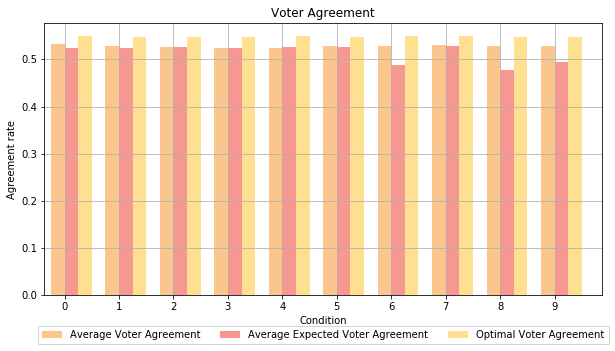

In [9]:
title = "Voter Agreement"
xlabel = "Condition"
xticklabels = labels
ylabel = "Agreement rate"
legend = ["Average Voter Agreement", "Average Expected Voter Agreement", "Optimal Voter Agreement"]
colours = ['#F78F1E', '#EE3224', '#FFC222']
name = "plot3_new"

data = pd.DataFrame([avg_regrets, avg_expected_regrets, avg_gold_regrets]).T
plot_bar_chart_3(data, title, xlabel, xticklabels, ylabel, legend, colours, name)

In [11]:
normalized_regrets_5 = normalized_regrets
coalitions_5 = avg_possible_coalitions

In [13]:
normalized_regrets_10 = normalized_regrets
coalitions_10 = avg_possible_coalitions

In [15]:
normalized_regrets_20 = normalized_regrets
coalitions_20 = avg_possible_coalitions

In [16]:
title = "Normalized Voter Agreement for increasing X"
xlabel = "Condition"
xticklabels = labels
ylabel = "Agreement rate"
legend = ["X = 4", "X = 6", "X = 10"]
colours = ['#F78F1E', '#EE3224', '#FFC222']
name = "plot2_new"

data = pd.DataFrame([normalized_regrets_5, normalized_regrets_10, normalized_regrets_20]).T

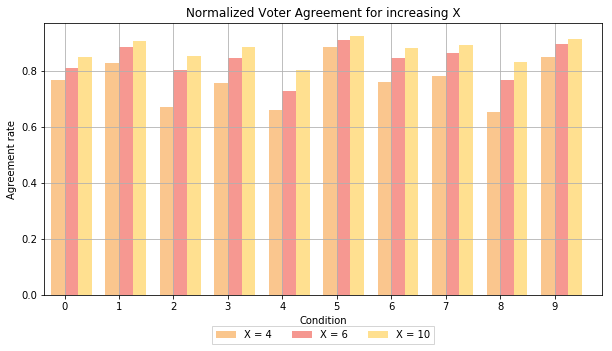

In [17]:
plot_bar_chart_3(data, title, xlabel, xticklabels, ylabel, legend, colours, name)
# E = 0: no breaking points
# E = 1: one random breaking point for the first party
# E = 2: one breaking point on the top issue of the first party
# E = 3: two leading parties have two 
# E = 4: one random breaking point per party
# E = 5: one top issue breaking podata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmQAAAE/CAYAAADosN8VAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzt3Xm8lXW5///XxQYEwdDESEWRU4p5mJRJcwDEMT0ap0xxzozUI3qy05fOt46n8fxsMvWbORxzqBT0qFkp5TyQQyEcnMVITVHSMAdAk8Hr98da0mKzYe+9ZO17r8Xr+Xjsh2vd9+e+7+taN27efO57rRWZiSRJkorTpegCJEmSNnQGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkNZSI6BERGRH917L+MxHxq46uS5LWxUAmaa0iYknFzzsR8VbF86Pew34fiIijWxlzckQ8VT7WnyPixojoWe0x35WZP87Mf3ov+4iIHSNiRStjNo+In0TESxHxRkTMi4gz3stxJTWurkUXIKnzysze7z6OiGeBEzPztlofNyL2B74CHJCZj0REX+CQWh93PfshsALYAVgM7AgMWp8HiIiumbnOYCipPjhDJqlqEdEUEf8REU9HxKKIuDIiNi2v6xUR0yPirxHxWkT8LiI2i4jvA6OAS8qzX99vYdejgJmZ+QhAZi7KzEsz863yvlebYYuIkyKieVD8eEQ8GxF/iYhvRUS0NDYiBkfEHRHxakQ8EREfr1jXKyLOi4jnI+L1iLg7IroC9wBNFbOFO6+lhysz8/XMfCczH8/Mn1fse1jFcf8cEV8oL+8ZEedHxMKIWBAR342IbuV1B0TE/PJr/hJwQXn5xIh4uPw6z4yInSqO8x/lfb1R7m/P1s6rpI5nIJP0XvwbsB+wB9AfWA78oLzuREqz8FsDfYFTgWWZ+QVgFqXZtt7l5809ABwSEWdGxG4R0b2K2v4JGA6MBiYBa1xijYj3AbcCPy7XeCxwaUR8uDzkPEozW6OA91OatUtgL2Bluf7emfm/a+nh2xFxXMX+3j3uZsBtwPXABynNot1TXv01YCgwBBgBjAP+T8Xm2wHdgG2A0yJiV+BHwKeBzYGfAjdERNeIGFZePhzoAxwELFjXiyapGAYySe/FScCXMvPFzPwbpTBxeHk2ajmwBfChzFyRmbMyc2lbdlq+LHoEMAa4GVgUEd+OiPb8zvr/MvO1zHyG0uXDSS2MmQg8mplXZubKzJwF/Ar4RHlW6lhgSmb+ubx+ZmaubOPxPwdcB3weeLJ8D9k+5XUfB+Zn5g8z8+3MfKN8bCgFx/8szwq+BHwTOKZiv28D38jMZeUZw88BP8zM2eUaLwY2ohTmVgA9gZ2Apsx8uvx6SOpkDGSSqlIOXdsAM8qXyl4D/pfS75XNKc063Q1cW7709l8R0dTW/WfmLzPzIGBT4DDgZFYPJq15vuLxn4CtWhgzANjr3frLPXwC2LL80xX4YzuOWVn/0sz8emYOp/R6/Aq4LiI2ofS6rbHf8mv6wXK9lbVvXfH8z5m5vFkP/7dZD1sAW2fmY8CXgG8BL5cvKferph9JtWUgk1SVzEzgBWDvzNy04qdHeXbn7cw8MzN3pHSJ7zBKs15QuuzX1uO8k5k3U7qkN7i8eCmwccWwD7aw6TYVj7cFXmxhzPPALc3q752Z/wospDTD9KGWympr/eUeXgfOAt5XruX5lvZbfk3/TClkVdb+wjqO/TxwZrMeNs7M68v7vCIzPwr8A9CD0oybpE7GQCbpvbgQOCsitgGIiA9ExD+VH+8TETuVLzO+QSncvFPe7iVKAaFFEfHJiDgsIjaNko8Cu1O6LwtgLvDJKH3m2I7A8S3sZmpE9ImI7Sjdv3Z1C2NuAHaOiMMjoltEdI+IXSNih/Is1E+AcyOiX/kNDHuUZ/lepnRT/7br6OGrEbFLeb89gdOARcD88nE/HKWP9ugeEe+LiFHlTacB/xmlj834APBl4GdrOw5wMTAlIkaWX6veEXFIRGxcfv3HRsRGwFvln3fWsS9JBTGQSXovvkPp5vQ7ImIxcB+wS3nd1sAvKH3kw6PADP4ein4AHFt+h+F3Wtjvq8AplC7rvQFcCnwtM6+rOG5X4C+UAklLgeUm4CHgQeB/WhqTma8C+1O68X0hpVm0b1K6aR5KIeqPlC7FvgJ8A4jydt8BZpcvEw5v4fhdysf8K6Ub6XcHPlaeOXwV2JfSjOHLwDxKb4wAOBN4HHiMUvC8t3ysFmXmveU6LwJeA54CjqQ0k9YT+D6lILgQ6A38x9r2Jak4UZohl6QNQ0ScAhycmR8ruhZJepczZJI2NP8I+E5DSZ2Kn9QvaYMREb+h9G7LTxRdiyRV8pKlJElSwbxkKUmSVDADmSRJUsHq7h6yvn375nbbbVd0GSxdupRevXoVXUZNNGpvjdoXNG5v9lV/GrW3Ru0LGre3ztLX7NmzF2XmFq2Nq7tAtt122/Hggw8WXQZ33XUX48aNK7qMmmjU3hq1L2jc3uyr/jRqb43aFzRub52lr4j4U+ujvGQpSZJUOAOZJElSwQxkkiRJBau7e8hasnz5chYsWMDf/va3Djtmnz59eOKJJzrseB2psrcePXrQv39/unXr1spWkiSpWg0RyBYsWMAmm2zCdtttR0R0yDEXL17MJpts0iHH6mjv9paZvPLKKyxYsICBAwcWXZYkSQ2rIS5Z/u1vf2PzzTfvsDC2oYgINt988w6deZQkaUPUEIEMMIzViK+rJEm11zCBrGhNTU0MHz6cwYMHc9hhh/Hmm29Wva8HHniAMWPGMHz4cD7ykY/w1a9+df0VKkmSOp2GuIesubcuOm+97q/n505rfUzPnsydOxeAo446igsvvJAzzjhj1frMJDPp0qX1DHzcccdxzTXXMGzYMFauXMm8efOqL75s5cqVNDU1vef9SJKk9c8ZshrYc889mT9/Ps8++yyDBg3i2GOPZfDgwTz//PPccsst7Lbbbuyyyy4cdthhLFmyZI3tX375ZbbcckugNPO20047AbBkyRI+/elPM2TIEIYOHcp1110HwLRp0xgyZAiDBw9m6tSpq/bTu3dvvvCFLzBs2DDuv/9+Zs+ezdixYxkxYgT7778/Cxcu7IBXQ5IktcZAtp6tWLGCX//61wwZMgSAP/zhD5xyyik89thj9OrVi29+85vcdtttzJkzh5EjR3L22WevsY/Pf/7zDBo0iIkTJ3LRRRetuqn+G9/4Bn369OGRRx7h4YcfZu+99+bFF19k6tSp3HHHHcydO5dZs2Zxww03AKXv8RozZgwPPfQQY8aMYcqUKVx77bXMnj2bE044gS9/+csd98JIkqS1ashLlh3ineXw9kurnr711lsMHzYYgD13H8Nnjj6YF1/8MwO27c+uOw+Et1/igZm38Pjjj7P77rsDsGzZMnbbbbc1dn3mmWdy1FFHccstt3DVVVcxbdo07rrrLm677TamT5++atxmm23GPffcw7hx49hii9L3lh511FHcc889fPzjH6epqYlPfOITAMybN49HH32UfffdFyhdwnx3Fk7qtJa9DH86t/3bDTh9/dciSTVkIFtPevbswdzf377G8l69Nl71OBP23Xdfpk2b1ur+PvShD3HyySfz2c9+li222IJXXnml3TX16NFj1X1jmck//uM/cv/997d7P5LUZtWEaAO05CXLjrTr6F249957mT9/PlC6pPjUU0+tMe6mm24iM4HSJc+mpiY23XRT9t13X84///xV41599VVGjx7N3XffzaJFi1i5ciXTpk1j7Nixa+xz0KBB/OUvf1kVyJYvX85jjz1WizYlSVI7Gcg60BZb9OXyyy9n0qRJDB06lN12240nn3xyjXE//elPGTRoEMOHD+eYY47hyiuvpKmpia985Su8+uqrDB48mGHDhnHnnXey5ZZbctZZZzF+/HiGDRvGiBEjOPTQQ9fYZ/fu3bn22muZOnUqw4YNY/jw4dx3330d0bYkSWpFQ16ybMvHVKxvS155eo1l2223LY/OuXu1ZXvvvTezZs1a574q7xOr1Lt3b6644oo1lk+aNIlJkyatWVOzd3AOHz6ce+65Z53HliRJHc8ZMkmSpIIZyCRJkgrWkJcsJXUuy+//QZVbbr1e6+g0/DgPSc0YyLTh8C9BSVInZSAD3lnyUuuD1tBtvdchqf5UN/vXoDN/qk9+dlynYCCTJKk1zrDXnzo7Zway9SR6fJCjjvgEP7u89MGtK1asYMvthjJm1C7c+POf8csbb+bxJ57iS1/55hrb9u7du8UvGf/Wt77FVVddRVNTE126dOGiiy5izJgxNe9FklR/vFezvjVkIGvvH8pctmYYqtR1xORW99Gr18Y8+viTvPXWW/Ts2ZNbb7+brbf6+3dFHnLw/hxy8P5trun+++/nxhtvZM6cOWy00UYsWrSIZcuWtXn7lqxYsYKuXdtwypt9Tycr3mj9Xxn+K1CSpKo1ZCArysf2n8BNv76NT/7zPzHt6p8z6VMfZ+a9vwPg8p9M58E5D/HDCy7lmWee4cgjj2TJkiUtfqo+wMKFC+nbty8bbbQRAH379l21btasWZx++uksXbqUjTbaiNtvv51u3bpx8skn8+CDD9K1a1fOPvtsxo8fz+WXX87111/PkiVLWLlyJXfffTff/e53ueaaa3j77beZOHEiX/va12r/4kiSVKUN4V5NA9l6dMSnPs7X/+v7HPyxfXn40Sc44bhJqwJZpdNPP52TTz6ZY489drXvpqy033778fWvf50ddtiBffbZh8MPP5yxY8eybNkyDj/8cK6++mpGjRrFG2+8Qc+ePTn33HOJCB555BGefPJJ9ttvP56cM5N3/vY6c2Y/yNz77+D979+M3/ziap56/GEeuONXZCaHfupY7vrNDey1x24VR/cNC0Wp+pLDsq29KVfrlZe/pI5lIFuPhg7ZiWf/9DzTrv45H9t/wlrH3XvvvVx33XUAHHPMMUydOnWNMb1792b27NnMnDmTO++8k8MPP5yzzjqLESNGsOWWWzJq1CgA3ve+9wHw29/+lilTpgCw4447MmDAAJ6aX/o6p33G78X7378ZALfefhe33nEXI3bfB4AlS5fyhz8+0yyQdW7+RSFJajQGsvXskIP259/+/evcdcv1vPLKX9c6LiJa3VdTUxPjxo1j3LhxDBkyhCuuuIIRI0a0u6ZevTZe9TgzmfqF0/jcCce2ez+SJKk2DGTr2QnHTWLTTfswZPBHuOvue1scs/vuuzN9+nSOPvporrzyyhbHzJs3jy5durD99tsDMHfuXAYMGMCgQYNYuHAhs2bNYtSoUSxevJiePXuy5557cuWVV7L33nvz1FNP8dxzzzFo+w8xZ+7Dq+13v33G85/f/DZHfeoT9O7dixdeXEi3bl35wBZbrN8XQpI6qQ3hfiTVHwPZeta//1ac9i8nrnPMueeey5FHHsm3v/3ttd7Uv2TJEqZMmcJrr71G165d+fCHP8zFF19M9+7dufrqq5kyZcqqd3TedtttnHLKKZx88skMGTKErl27cvnll696Q0Cl/SaM48l5f2D3CQcB0LtXL35yyfkGMkmSCtSQgazbbp9v1/jqPql/dUteeXqNZePG7s64sbsDcPyxR3D8sUcAMHDgQO6///5V4775zTU/m2zEiBHcd999LR5r1KhRPPDAA2ssv+yyy1Z7/s6Slzj+6CM4/ugjVlt+2imf5bRTPttKR5IkqaN0KboASZKkDZ2BTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBrL1pGnjrRg+egKDdxnLYUeeyJtvvtnufZxzzjlr3e7GG29k5513ZtiwYey0005cdNFF77VkSZLUSTTk55C190uWY9mSda7PLdf9Qa8APXv2YO7vbwfgqONO4cL//glnnH5Su+o455xzOProo9l4441XW758+XImT57M73//e/r378/bb7/Ns88+2659N5eZZCZdupjJJUkqmn8b18Cee4xh/h+fAeDscy9k8C5jGbzLWM75fxcDsHTpUg466CCGDRvG4MGDufrqqznvvPN48cUXGT9+POPHj19tf4sXL2bFihVsvvnmAGy00UYMGjQIgJdeeomJEycybNgwhg0bturDZM8++2yGjh7L0NFjOff80nGf/dNzfGTn3Tlu8qkMHT2W5xe8wC2338Xuex/EyD325VPHnMiSJUs75DWSJEl/15gzZAVasWIFv775Dg7Ybzyz5zzEZT+Zzu9mziATxux5IGMnHMzTTz/NVlttxU033QTA66+/Tp8+fTj77LO588476du372r7fP/7388hhxzCgAEDmDBhAgcffDCTJk2iS5cunHbaaYwdO5af//znrFy5kiVLljB79mwuu+wy7r+zdNzdxh/IXnvsxmab9uEPf3yayy46j11Hj2DRolf4r++cwy2/uoZevXrxnbP/Hz/44YWc8cUvFfHSSZK0wXKGbD15662/MXz0BEZ+dH+23WZrPnP8kfz2vt8z8ZAD6dWrF7179+KfDz2ImTNnMmTIEG699VamTp3KzJkz6dOnT6v7v+SSS7j99tsZPXo03/ve9zjhhBMAuOOOOzj55JMBaGpqok+fPvz2t79l4sSJq4478ZCD+O19vwNgwLb92XX0CAAemDWbx598ij33PYRdPjqBn1x1DX96bkGNXiFJkrQ2zpCtJ5X3kLVmhx12YM6cOcyYMYOvfOUrTJgwgTPPPLPV7YYMGcKQIUM45phjGDhwIJdffnm76+xVcX9aJuyz915cddmFq41ZurLdu5UkSe+BM2Q1tOfuY7jhV7/hzTffZOnSpfz8lzPYc889efHFF9l44405+uij+eIXv8icOXMA2GSTTVi8ePEa+1myZAl33XXXqudz585lwIABAEyYMIELLrgAgJUrV/L666+z5557csMNN6w67g2/msEeHx2zxn53HbUL9z0wa9X9bkuXLuWpP/xxfb8MkiSpFc6Q1dAuOw/l+GMOZ/QeBwJw4qePYuedd+bmm2/mi1/8Il26dKFbt26rAtXkyZM54IAD2GqrrbjzzjtX7Scz+c53vsPnPvc5evbsSa9evVbNjp177rlMnjyZH//4xzQ1NXHBBRew2267cfzxx7PruNJxP3PcUew8bAjP/um51erbYou+XHrhuRx1wkm8/fYyAL7+H19i63/YsdYvjSRJqtCYgWzA6e0anktees+HXPLK0y0uP+P0k9b4+Iv999+f/ffff42xU6ZMYcqUKWss32STTZgxY0aL++/Xrx+/+MUv1jzuGWfwr5OPWm3ZdgO25eHf373asr3H7sHv7r55tWVespQkqWN5yVKSJKlgNZ0hi4gDgHOBJuCSzDyr2fo+wM+Abcu1fC8zL6tlTVJHeOui86raruvQ9VyIJKku1GyGLCKagPOBA4GdgEkRsVOzYf8CPJ6Zw4BxwPcjonutapIkSeqMajlDNhqYn5lPA0TEdOBQ4PGKMQlsEhEB9Ab+Cqyo5mCZSWk3Wp8ys+gSJKlFzkSrkUSt/sKNiE8CB2TmieXnxwBjMvPUijGbAL8EdgQ2AQ7PzJta2NdkYDJAv379RkyfPn219b1796Zfv3706dOnqlCWK5e3e5t3CJqiiteuS7f2b1OlavqCv/eWmbz+xmJe+vMLLHnthXVv1P0DVR2rGrn05aq2W7qyG717VPGaVNFbLqquRnpWt1lVvXnO1otqemvUvqBj/yx25P9nnrNmOrAvqO//z8aPHz87M0e2Nq7od1nuD8wF9gY+BNwaETMz843KQZl5MXAxwMiRI3PcuHGr7WT58uUsWLCAF15oJTSsRb79RuuDmnn7nSZ6dKvi7Yhd39f+bapUTV+wem89mpYwbIt5dOvXyh/qAZ+q6ljVWH7/D6ra7t7FWzNu0ML2b1hFb9X/y726t7hW1ZvnbL2oprdG7Qs69s9iR/5/5jlrxnO23tUykL0AbFPxvH95WaVPA2dlaZpufkQ8Q2m27PftOVC3bt0YOHBg1YVW+wt156pOdPs+kgOK+cu9qt6qUE1vXm6QJDWaWn7sxSxg+4gYWL5R/whKlycrPQdMAIiIfsAgoOUP9JIkSWpQNZshy8wVEXEqcDOlj724NDMfi4iTyusvBL4BXB4RjwABTM3MRbWqSZIkqTOq6T1kmTkDmNFs2YUVj18E9qtlDZIkSZ1d0Tf1S1Kn4EcoSCqSX50kSZJUMAOZJElSwQxkkiRJBTOQSZIkFcyb+iWpwfkBzFLn5wyZJElSwQxkkiRJBTOQSZIkFcx7yCRJ6mS872/D4wyZJElSwQxkkiRJBfOSpaR28VKKJK1/zpBJkiQVrKFmyKr5lzv4r3dJklQsZ8gkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKlhNA1lEHBAR8yJifkR8aS1jxkXE3Ih4LCLurmU9kiRJnVHXWu04IpqA84F9gQXArIj4ZWY+XjFmU+BHwAGZ+VxEfKBW9UiSJHVWtZwhGw3Mz8ynM3MZMB04tNmYI4HrM/M5gMx8uYb1SJIkdUq1DGRbA89XPF9QXlZpB2CziLgrImZHxLE1rEeSJKlTisyszY4jPknpUuSJ5efHAGMy89SKMT8ERgITgJ7A/cBBmflUs31NBiYD9OvXb8T06dNbPGYuqnKCrWf7N1m6shu9eyxv/4bd239VtiP7gip7q6IvqLK3juwLPGfNeM6a6eS/P6AOzllH9gWes2Y8Z81U2dvajB8/fnZmjmxtXM3uIQNeALapeN6/vKzSAuCVzFwKLI2Ie4BhwGqBLDMvBi4GGDlyZI4bN67FA7510XlVFdp16Mp2b3Pv4q0ZN2hh+w824FPt3qQj+4Iqe6uiL6iutw7tCzxnzXjOVtfZf39AHZyzDuwLPGfNec6aqbK396qWlyxnAdtHxMCI6A4cAfyy2ZhfAHtERNeI2BgYAzxRw5okSZI6nZrNkGXmiog4FbgZaAIuzczHIuKk8voLM/OJiPgN8DDwDnBJZj5aq5okSZI6o1pesiQzZwAzmi27sNnz7wLfrWUdkiRJnZmf1C9JklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBWszYEsIvaIiE+XH28REQNrV5YkSdKGo02BLCL+E5gK/Ht5UTfgZ7UqSpIkaUPS1hmyicAhwFKAzHwR2KRWRUmSJG1I2hrIlmVmAgkQEb1qV5IkSdKGpa2B7JqIuAjYNCI+C9wG/HftypIkSdpwdG3LoMz8XkTsC7wBDALOzMxba1qZJEnSBqLVQBYRTcBtmTkeMIRJkiStZ61esszMlcA7EdGnA+qRJEna4LTpkiWwBHgkIm6l/E5LgMw8rSZVSZIkbUDaGsiuL/9IkiRpPWvrTf1XRER3YIfyonmZubx2ZUmSJG042hTIImIccAXwLBDANhFxXGbeU7vSJEmSNgxtvWT5fWC/zJwHEBE7ANOAEbUqTJIkaUPR1g+G7fZuGAPIzKcofZ+lJEmS3qO2zpA9GBGX8PcvFD8KeLA2JUmSJG1Y2hrITgb+BXj3Yy5mAj+qSUWSJEkbmLYGsq7AuZl5Nqz69P6NalaVJEnSBqSt95DdDvSseN6T0heMS5Ik6T1qayDrkZlL3n1SfrxxbUqSJEnasLQ1kC2NiF3efRIRI4G3alOSJEnShqWt95D9K/A/EfFi+fmWwOG1KUmSJGnDss4ZsogYFREfzMxZwI7A1cBy4DfAMx1QnyRJUsNr7ZLlRcCy8uPdgP8LnA+8Clxcw7okSZI2GK1dsmzKzL+WHx8OXJyZ1wHXRcTc2pYmSZK0YWhthqwpIt4NbROAOyrWtfX+M0mSJK1Da6FqGnB3RCyi9K7KmQAR8WHg9RrXJkmStEFYZyDLzG9FxO2U3lV5S2ZmeVUXYEqti5MkSdoQtHrZMTMfaGHZU7UpR5IkacPT1g+GlSRJUo0YyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKVtNAFhEHRMS8iJgfEV9ax7hREbEiIj5Zy3okSZI6o5oFsohoovRF5AcCOwGTImKntYz7NnBLrWqRJEnqzGo5QzYamJ+ZT2fmMmA6cGgL46YA1wEv17AWSZKkTquWgWxr4PmK5wvKy1aJiK2BicAFNaxDkiSpU4u/fz3let5x6X6wAzLzxPLzY4AxmXlqxZj/Ab6fmQ9ExOXAjZl5bQv7mgxMBujXr9+I6dOnt3jMXFTlJFvP9m+ydGU3evdY3v4Nu3+g3Zt0ZF9QZW9V9AVV9taRfYHnrBnPWTOd/PcH1ME568i+wHPWjOesmSp7W5vx48fPzsyRrY1r9bss34MXgG0qnvcvL6s0EpgeEQB9gY9FxIrMvKFyUGZeDFwMMHLkyBw3blyLB3zrovOqKrTr0JXt3ubexVszbtDC9h9swKfavUlH9gVV9lZFX1Bdbx3aF3jOmvGcra6z//6AOjhnHdgXeM6a85w1U2Vv71UtA9ksYPuIGEgpiB0BHFk5IDMHvvu4YoZstTAmSZLU6GoWyDJzRUScCtwMNAGXZuZjEXFSef2FtTq2JElSPanlDBmZOQOY0WxZi0EsM4+vZS2SJEmdlZ/UL0mSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVKi4T3IAAAKBklEQVTBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwWoayCLigIiYFxHzI+JLLaw/KiIejohHIuK+iBhWy3okSZI6o5oFsohoAs4HDgR2AiZFxE7Nhj0DjM3MIcA3gItrVY8kSVJnVcsZstHA/Mx8OjOXAdOBQysHZOZ9mflq+ekDQP8a1iNJktQp1TKQbQ08X/F8QXnZ2nwG+HUN65EkSeqUIjNrs+OITwIHZOaJ5efHAGMy89QWxo4HfgTskZmvtLB+MjAZoF+/fiOmT5/e4jFz0cvVFduz/ZssXdmN3j2Wt3/D7h9o9yYd2RdU2VsVfUGVvXVkX+A5a8Zz1kwn//0BdXDOOrIv8Jw14zlrpsre1mb8+PGzM3Nka+O6rtejru4FYJuK5/3Ly1YTEUOBS4ADWwpjAJl5MeX7y0aOHJnjxo1r8YBvXXReVYV2Hbqy3dvcu3hrxg1a2P6DDfhUuzfpyL6gyt6q6Auq661D+wLPWTOes9V19t8fUAfnrAP7As9Zc56zZqrs7b2q5SXLWcD2ETEwIroDRwC/rBwQEdsC1wPHZOZTNaxFkiSp06rZDFlmroiIU4GbgSbg0sx8LCJOKq+/EDgT2Bz4UUQArGjLtJ4kSVIjqeUlSzJzBjCj2bILKx6fCJxYyxokSZI6Oz+pX5IkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkgtU0kEXEARExLyLmR8SXWlgfEXFeef3DEbFLLeuRJEnqjGoWyCKiCTgfOBDYCZgUETs1G3YgsH35ZzJwQa3qkSRJ6qxqOUM2GpifmU9n5jJgOnBoszGHAj/JkgeATSNiyxrWJEmS1OnUMpBtDTxf8XxBeVl7x0iSJDW0yMza7Djik8ABmXli+fkxwJjMPLVizI3AWZn52/Lz24Gpmflgs31NpnRJE2AQMK8mRbdPX2BR0UXUSKP21qh9QeP2Zl/1p1F7a9S+oHF76yx9DcjMLVob1LWGBbwAbFPxvH95WXvHkJkXAxev7wLfi4h4MDNHFl1HLTRqb43aFzRub/ZVfxq1t0btCxq3t3rrq5aXLGcB20fEwIjoDhwB/LLZmF8Cx5bfbbkr8HpmLqxhTZIkSZ1OzWbIMnNFRJwK3Aw0AZdm5mMRcVJ5/YXADOBjwHzgTeDTtapHkiSps6rlJUsycwal0FW57MKKxwn8Sy1rqKFOdQl1PWvU3hq1L2jc3uyr/jRqb43aFzRub3XVV81u6pckSVLb+NVJkiRJBTOQ0aaveDq0/NVOcyPiwYjYo7x8UHnZuz9vRMS/ltd9NSJeqFj3sQL6ujQiXo6IR9eyvl772iYi7oyIxyPisYg4vYF66xERv4+Ih8q9fa1ReivX0RQR/1v+yJvm6+q5r2cj4pF3a29hfV32FhGbRsS1EfFkRDwREbs1SF9rra8Bevt8+XfHoxExLSJ6NEhfp5d7eqz5uarnvlaTmRv0D6U3HPwR+AegO/AQsFOzMb35++XdocCTa9nPnyl93gjAV4F/K7i3vYBdgEfXsr5e+9oS2KX8eBPgqQY6ZwH0Lj/uBvwO2LUReivXcQZwFXBjo/x5LNfxLNB3HevrsjfgCuDE8uPuwKaN0Ne66qvn3ih9sPozQM/y82uA4xugr8HAo8DGlO59vw34cL331fzHGbI2fMVTZi7J8tkDegEt3Xg3AfhjZv6pptW2Q2beA/x1Hevrta+FmTmn/Hgx8ATNvuGhjnvLzFxSftqt/JPNxtRlbxHRHzgIuKSl9fXaV1vUY28R0YfSP+p+DJCZyzLztcox9dhXC1qsr4576wr0jIiulALMi5Ur67SvjwC/y8w3M3MFcDfwz5UD6rSv1RjI2vj1TRExMSKeBG4CTmhhP0cA05otm1KeQr00IjZbXwWvT/XeV0RsB+xMaSap+bq67C1Kl/XmAi8Dt2Zmo/R2DvB/gHfWNqBO+4LSL//bImJ2lL5ZZA112NtA4C/AZVG6zHxJRPRqPqgO+2qupfqA+ustM18Avgc8Byyk9NmetzQfV299UZod2zMiNo+IjSl9XNY2zQfVYV+rK3qKrugf4JPAJRXPjwF+uI7xewG3NVvWndLXM/SrWNaP0vRoF+BblD6HrYj+tmMtlyzrua9yLb2B2cA/N1pv5Xo2Be4EBtd7b8DBwI/Kj8fRwiXLeuyroo6ty//9AKXbHvaq996AkcAKSl95B3Au8I1676u1+uq5N2Az4A5gC0qz6zcAR9d7X+UaPkPp9/09wAXAOY3QV+WPM2Rt/Pqmd2XpMuA/RETfisUHAnMy86WKcS9l5srMfAf4b0qXRjuteusrIroB1wFXZub16xpbb71V1PMapUB2wDrG1EtvuwOHRMSzlG4L2Dsifra2wXXU17t1vFD+78vAz9dVRx31tgBYkH+fob2W0j2pLaqjviqtUV9L6qi3fYBnMvMvmbkcuB746NoG11FfZOaPM3NEZu4FvErp3uG1ja2bvioZyNrwFU8R8eGIiPLjXYCNgFcqhkyi2TRoRGxZ8XQipSnXTqVe+yrX/GPgicw8ey1j6rW3LSJi0/LjnsC+wJPNxtRdb5n575nZPzO3o/T/2B2ZeXTlmHrsq1xDr4jY5N3HwH7N66jH3jLzz8DzETGovGgC8HjlmHrsq5k16ntXnfb2HLBrRGxcrn0CpXtsV6nTvoiID5T/uy2l+8euara+LvtaTZHTc53lh9L16Kcovdvyy+VlJwEnlR9PBR4D5gL3A3tUbNuL0knv02yfPwUeAR6mFPC2LKCvaZTuI1hO6V+7n2mQvvagdM/Ow+Xa55bPYSP0NhT433INjwJnNsqfx4paxlG+ZNkIfVF6h/ZD5Z/HGux3yHDgwXINN1C6JFb3fa2tvkboDfgapX/EPVquZ6MG6WsmpX8QPARMaJTzVfnjJ/VLkiQVzEuWkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLB/n9Co+MSHy5+pAAAAABJRU5ErkJggg==int per party
# E = 6: two random breaking points per party
# E = 7: two top issue breaking points per party
# E = 8: one breaking point on the top issue of the first party + vote revaluation

In [18]:
data = pd.DataFrame([coalitions_5, coalitions_10, coalitions_20]).T

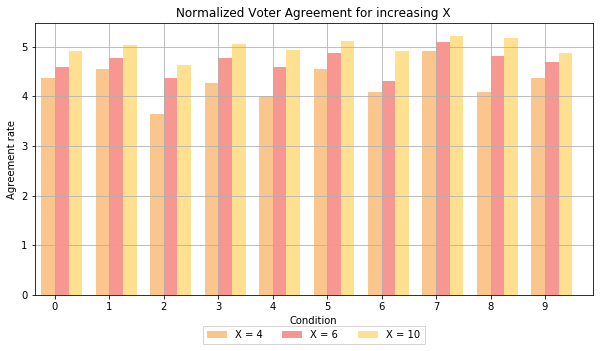

In [19]:
plot_bar_chart_3(data, title, xlabel, xticklabels, ylabel, legend, colours, name)
# E = 0: no breaking points
# E = 1: one random breaking point for the first party
# E = 2: one breaking point on the top issue of the first party
# E = 3: two leading parties have two 
# E = 4: one random breaking point per party
# E = 5: one top issue breaking podata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAmQAAAE/CAYAAADosN8VAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzt3Xm8lXW5///XxQYEwdDESEWRU4p5mJRJcwDEMT0ap0xxzozUI3qy05fOt46n8fxsMvWbORxzqBT0qFkp5TyQQyEcnMVITVHSMAdAk8Hr98da0mKzYe+9ZO17r8Xr+Xjsh2vd9+e+7+taN27efO57rRWZiSRJkorTpegCJEmSNnQGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkNZSI6BERGRH917L+MxHxq46uS5LWxUAmaa0iYknFzzsR8VbF86Pew34fiIijWxlzckQ8VT7WnyPixojoWe0x35WZP87Mf3ov+4iIHSNiRStjNo+In0TESxHxRkTMi4gz3stxJTWurkUXIKnzysze7z6OiGeBEzPztlofNyL2B74CHJCZj0REX+CQWh93PfshsALYAVgM7AgMWp8HiIiumbnOYCipPjhDJqlqEdEUEf8REU9HxKKIuDIiNi2v6xUR0yPirxHxWkT8LiI2i4jvA6OAS8qzX99vYdejgJmZ+QhAZi7KzEsz863yvlebYYuIkyKieVD8eEQ8GxF/iYhvRUS0NDYiBkfEHRHxakQ8EREfr1jXKyLOi4jnI+L1iLg7IroC9wBNFbOFO6+lhysz8/XMfCczH8/Mn1fse1jFcf8cEV8oL+8ZEedHxMKIWBAR342IbuV1B0TE/PJr/hJwQXn5xIh4uPw6z4yInSqO8x/lfb1R7m/P1s6rpI5nIJP0XvwbsB+wB9AfWA78oLzuREqz8FsDfYFTgWWZ+QVgFqXZtt7l5809ABwSEWdGxG4R0b2K2v4JGA6MBiYBa1xijYj3AbcCPy7XeCxwaUR8uDzkPEozW6OA91OatUtgL2Bluf7emfm/a+nh2xFxXMX+3j3uZsBtwPXABynNot1TXv01YCgwBBgBjAP+T8Xm2wHdgG2A0yJiV+BHwKeBzYGfAjdERNeIGFZePhzoAxwELFjXiyapGAYySe/FScCXMvPFzPwbpTBxeHk2ajmwBfChzFyRmbMyc2lbdlq+LHoEMAa4GVgUEd+OiPb8zvr/MvO1zHyG0uXDSS2MmQg8mplXZubKzJwF/Ar4RHlW6lhgSmb+ubx+ZmaubOPxPwdcB3weeLJ8D9k+5XUfB+Zn5g8z8+3MfKN8bCgFx/8szwq+BHwTOKZiv28D38jMZeUZw88BP8zM2eUaLwY2ohTmVgA9gZ2Apsx8uvx6SOpkDGSSqlIOXdsAM8qXyl4D/pfS75XNKc063Q1cW7709l8R0dTW/WfmLzPzIGBT4DDgZFYPJq15vuLxn4CtWhgzANjr3frLPXwC2LL80xX4YzuOWVn/0sz8emYOp/R6/Aq4LiI2ofS6rbHf8mv6wXK9lbVvXfH8z5m5vFkP/7dZD1sAW2fmY8CXgG8BL5cvKferph9JtWUgk1SVzEzgBWDvzNy04qdHeXbn7cw8MzN3pHSJ7zBKs15QuuzX1uO8k5k3U7qkN7i8eCmwccWwD7aw6TYVj7cFXmxhzPPALc3q752Z/wospDTD9KGWympr/eUeXgfOAt5XruX5lvZbfk3/TClkVdb+wjqO/TxwZrMeNs7M68v7vCIzPwr8A9CD0oybpE7GQCbpvbgQOCsitgGIiA9ExD+VH+8TETuVLzO+QSncvFPe7iVKAaFFEfHJiDgsIjaNko8Cu1O6LwtgLvDJKH3m2I7A8S3sZmpE9ImI7Sjdv3Z1C2NuAHaOiMMjoltEdI+IXSNih/Is1E+AcyOiX/kNDHuUZ/lepnRT/7br6OGrEbFLeb89gdOARcD88nE/HKWP9ugeEe+LiFHlTacB/xmlj834APBl4GdrOw5wMTAlIkaWX6veEXFIRGxcfv3HRsRGwFvln3fWsS9JBTGQSXovvkPp5vQ7ImIxcB+wS3nd1sAvKH3kw6PADP4ein4AHFt+h+F3Wtjvq8AplC7rvQFcCnwtM6+rOG5X4C+UAklLgeUm4CHgQeB/WhqTma8C+1O68X0hpVm0b1K6aR5KIeqPlC7FvgJ8A4jydt8BZpcvEw5v4fhdysf8K6Ub6XcHPlaeOXwV2JfSjOHLwDxKb4wAOBN4HHiMUvC8t3ysFmXmveU6LwJeA54CjqQ0k9YT+D6lILgQ6A38x9r2Jak4UZohl6QNQ0ScAhycmR8ruhZJepczZJI2NP8I+E5DSZ2Kn9QvaYMREb+h9G7LTxRdiyRV8pKlJElSwbxkKUmSVDADmSRJUsHq7h6yvn375nbbbVd0GSxdupRevXoVXUZNNGpvjdoXNG5v9lV/GrW3Ru0LGre3ztLX7NmzF2XmFq2Nq7tAtt122/Hggw8WXQZ33XUX48aNK7qMmmjU3hq1L2jc3uyr/jRqb43aFzRub52lr4j4U+ujvGQpSZJUOAOZJElSwQxkkiRJBau7e8hasnz5chYsWMDf/va3Djtmnz59eOKJJzrseB2psrcePXrQv39/unXr1spWkiSpWg0RyBYsWMAmm2zCdtttR0R0yDEXL17MJpts0iHH6mjv9paZvPLKKyxYsICBAwcWXZYkSQ2rIS5Z/u1vf2PzzTfvsDC2oYgINt988w6deZQkaUPUEIEMMIzViK+rJEm11zCBrGhNTU0MHz6cwYMHc9hhh/Hmm29Wva8HHniAMWPGMHz4cD7ykY/w1a9+df0VKkmSOp2GuIesubcuOm+97q/n505rfUzPnsydOxeAo446igsvvJAzzjhj1frMJDPp0qX1DHzcccdxzTXXMGzYMFauXMm8efOqL75s5cqVNDU1vef9SJKk9c8ZshrYc889mT9/Ps8++yyDBg3i2GOPZfDgwTz//PPccsst7Lbbbuyyyy4cdthhLFmyZI3tX375ZbbcckugNPO20047AbBkyRI+/elPM2TIEIYOHcp1110HwLRp0xgyZAiDBw9m6tSpq/bTu3dvvvCFLzBs2DDuv/9+Zs+ezdixYxkxYgT7778/Cxcu7IBXQ5IktcZAtp6tWLGCX//61wwZMgSAP/zhD5xyyik89thj9OrVi29+85vcdtttzJkzh5EjR3L22WevsY/Pf/7zDBo0iIkTJ3LRRRetuqn+G9/4Bn369OGRRx7h4YcfZu+99+bFF19k6tSp3HHHHcydO5dZs2Zxww03AKXv8RozZgwPPfQQY8aMYcqUKVx77bXMnj2bE044gS9/+csd98JIkqS1ashLlh3ineXw9kurnr711lsMHzYYgD13H8Nnjj6YF1/8MwO27c+uOw+Et1/igZm38Pjjj7P77rsDsGzZMnbbbbc1dn3mmWdy1FFHccstt3DVVVcxbdo07rrrLm677TamT5++atxmm23GPffcw7hx49hii9L3lh511FHcc889fPzjH6epqYlPfOITAMybN49HH32UfffdFyhdwnx3Fk7qtJa9DH86t/3bDTh9/dciSTVkIFtPevbswdzf377G8l69Nl71OBP23Xdfpk2b1ur+PvShD3HyySfz2c9+li222IJXXnml3TX16NFj1X1jmck//uM/cv/997d7P5LUZtWEaAO05CXLjrTr6F249957mT9/PlC6pPjUU0+tMe6mm24iM4HSJc+mpiY23XRT9t13X84///xV41599VVGjx7N3XffzaJFi1i5ciXTpk1j7Nixa+xz0KBB/OUvf1kVyJYvX85jjz1WizYlSVI7Gcg60BZb9OXyyy9n0qRJDB06lN12240nn3xyjXE//elPGTRoEMOHD+eYY47hyiuvpKmpia985Su8+uqrDB48mGHDhnHnnXey5ZZbctZZZzF+/HiGDRvGiBEjOPTQQ9fYZ/fu3bn22muZOnUqw4YNY/jw4dx3330d0bYkSWpFQ16ybMvHVKxvS155eo1l2223LY/OuXu1ZXvvvTezZs1a574q7xOr1Lt3b6644oo1lk+aNIlJkyatWVOzd3AOHz6ce+65Z53HliRJHc8ZMkmSpIIZyCRJkgrWkJcsJXUuy+//QZVbbr1e6+g0/DgPSc0YyLTh8C9BSVInZSAD3lnyUuuD1tBtvdchqf5UN/vXoDN/qk9+dlynYCCTJKk1zrDXnzo7Zway9SR6fJCjjvgEP7u89MGtK1asYMvthjJm1C7c+POf8csbb+bxJ57iS1/55hrb9u7du8UvGf/Wt77FVVddRVNTE126dOGiiy5izJgxNe9FklR/vFezvjVkIGvvH8pctmYYqtR1xORW99Gr18Y8+viTvPXWW/Ts2ZNbb7+brbf6+3dFHnLw/hxy8P5trun+++/nxhtvZM6cOWy00UYsWrSIZcuWtXn7lqxYsYKuXdtwypt9Tycr3mj9Xxn+K1CSpKo1ZCArysf2n8BNv76NT/7zPzHt6p8z6VMfZ+a9vwPg8p9M58E5D/HDCy7lmWee4cgjj2TJkiUtfqo+wMKFC+nbty8bbbQRAH379l21btasWZx++uksXbqUjTbaiNtvv51u3bpx8skn8+CDD9K1a1fOPvtsxo8fz+WXX87111/PkiVLWLlyJXfffTff/e53ueaaa3j77beZOHEiX/va12r/4kiSVKUN4V5NA9l6dMSnPs7X/+v7HPyxfXn40Sc44bhJqwJZpdNPP52TTz6ZY489drXvpqy033778fWvf50ddtiBffbZh8MPP5yxY8eybNkyDj/8cK6++mpGjRrFG2+8Qc+ePTn33HOJCB555BGefPJJ9ttvP56cM5N3/vY6c2Y/yNz77+D979+M3/ziap56/GEeuONXZCaHfupY7vrNDey1x24VR/cNC0Wp+pLDsq29KVfrlZe/pI5lIFuPhg7ZiWf/9DzTrv45H9t/wlrH3XvvvVx33XUAHHPMMUydOnWNMb1792b27NnMnDmTO++8k8MPP5yzzjqLESNGsOWWWzJq1CgA3ve+9wHw29/+lilTpgCw4447MmDAAJ6aX/o6p33G78X7378ZALfefhe33nEXI3bfB4AlS5fyhz8+0yyQdW7+RSFJajQGsvXskIP259/+/evcdcv1vPLKX9c6LiJa3VdTUxPjxo1j3LhxDBkyhCuuuIIRI0a0u6ZevTZe9TgzmfqF0/jcCce2ez+SJKk2DGTr2QnHTWLTTfswZPBHuOvue1scs/vuuzN9+nSOPvporrzyyhbHzJs3jy5durD99tsDMHfuXAYMGMCgQYNYuHAhs2bNYtSoUSxevJiePXuy5557cuWVV7L33nvz1FNP8dxzzzFo+w8xZ+7Dq+13v33G85/f/DZHfeoT9O7dixdeXEi3bl35wBZbrN8XQpI6qQ3hfiTVHwPZeta//1ac9i8nrnPMueeey5FHHsm3v/3ttd7Uv2TJEqZMmcJrr71G165d+fCHP8zFF19M9+7dufrqq5kyZcqqd3TedtttnHLKKZx88skMGTKErl27cvnll696Q0Cl/SaM48l5f2D3CQcB0LtXL35yyfkGMkmSCtSQgazbbp9v1/jqPql/dUteeXqNZePG7s64sbsDcPyxR3D8sUcAMHDgQO6///5V4775zTU/m2zEiBHcd999LR5r1KhRPPDAA2ssv+yyy1Z7/s6Slzj+6CM4/ugjVlt+2imf5bRTPttKR5IkqaN0KboASZKkDZ2BTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBrL1pGnjrRg+egKDdxnLYUeeyJtvvtnufZxzzjlr3e7GG29k5513ZtiwYey0005cdNFF77VkSZLUSTTk55C190uWY9mSda7PLdf9Qa8APXv2YO7vbwfgqONO4cL//glnnH5Su+o455xzOProo9l4441XW758+XImT57M73//e/r378/bb7/Ns88+2659N5eZZCZdupjJJUkqmn8b18Cee4xh/h+fAeDscy9k8C5jGbzLWM75fxcDsHTpUg466CCGDRvG4MGDufrqqznvvPN48cUXGT9+POPHj19tf4sXL2bFihVsvvnmAGy00UYMGjQIgJdeeomJEycybNgwhg0bturDZM8++2yGjh7L0NFjOff80nGf/dNzfGTn3Tlu8qkMHT2W5xe8wC2338Xuex/EyD325VPHnMiSJUs75DWSJEl/15gzZAVasWIFv775Dg7Ybzyz5zzEZT+Zzu9mziATxux5IGMnHMzTTz/NVlttxU033QTA66+/Tp8+fTj77LO588476du372r7fP/7388hhxzCgAEDmDBhAgcffDCTJk2iS5cunHbaaYwdO5af//znrFy5kiVLljB79mwuu+wy7r+zdNzdxh/IXnvsxmab9uEPf3yayy46j11Hj2DRolf4r++cwy2/uoZevXrxnbP/Hz/44YWc8cUvFfHSSZK0wXKGbD15662/MXz0BEZ+dH+23WZrPnP8kfz2vt8z8ZAD6dWrF7179+KfDz2ImTNnMmTIEG699VamTp3KzJkz6dOnT6v7v+SSS7j99tsZPXo03/ve9zjhhBMAuOOOOzj55JMBaGpqok+fPvz2t79l4sSJq4478ZCD+O19vwNgwLb92XX0CAAemDWbx598ij33PYRdPjqBn1x1DX96bkGNXiFJkrQ2zpCtJ5X3kLVmhx12YM6cOcyYMYOvfOUrTJgwgTPPPLPV7YYMGcKQIUM45phjGDhwIJdffnm76+xVcX9aJuyz915cddmFq41ZurLdu5UkSe+BM2Q1tOfuY7jhV7/hzTffZOnSpfz8lzPYc889efHFF9l44405+uij+eIXv8icOXMA2GSTTVi8ePEa+1myZAl33XXXqudz585lwIABAEyYMIELLrgAgJUrV/L666+z5557csMNN6w67g2/msEeHx2zxn53HbUL9z0wa9X9bkuXLuWpP/xxfb8MkiSpFc6Q1dAuOw/l+GMOZ/QeBwJw4qePYuedd+bmm2/mi1/8Il26dKFbt26rAtXkyZM54IAD2GqrrbjzzjtX7Scz+c53vsPnPvc5evbsSa9evVbNjp177rlMnjyZH//4xzQ1NXHBBRew2267cfzxx7PruNJxP3PcUew8bAjP/um51erbYou+XHrhuRx1wkm8/fYyAL7+H19i63/YsdYvjSRJqtCYgWzA6e0anktees+HXPLK0y0uP+P0k9b4+Iv999+f/ffff42xU6ZMYcqUKWss32STTZgxY0aL++/Xrx+/+MUv1jzuGWfwr5OPWm3ZdgO25eHf373asr3H7sHv7r55tWVespQkqWN5yVKSJKlgNZ0hi4gDgHOBJuCSzDyr2fo+wM+Abcu1fC8zL6tlTVJHeOui86raruvQ9VyIJKku1GyGLCKagPOBA4GdgEkRsVOzYf8CPJ6Zw4BxwPcjonutapIkSeqMajlDNhqYn5lPA0TEdOBQ4PGKMQlsEhEB9Ab+Cqyo5mCZSWk3Wp8ys+gSJKlFzkSrkUSt/sKNiE8CB2TmieXnxwBjMvPUijGbAL8EdgQ2AQ7PzJta2NdkYDJAv379RkyfPn219b1796Zfv3706dOnqlCWK5e3e5t3CJqiiteuS7f2b1OlavqCv/eWmbz+xmJe+vMLLHnthXVv1P0DVR2rGrn05aq2W7qyG717VPGaVNFbLqquRnpWt1lVvXnO1otqemvUvqBj/yx25P9nnrNmOrAvqO//z8aPHz87M0e2Nq7od1nuD8wF9gY+BNwaETMz843KQZl5MXAxwMiRI3PcuHGr7WT58uUsWLCAF15oJTSsRb79RuuDmnn7nSZ6dKvi7Yhd39f+bapUTV+wem89mpYwbIt5dOvXyh/qAZ+q6ljVWH7/D6ra7t7FWzNu0ML2b1hFb9X/y726t7hW1ZvnbL2oprdG7Qs69s9iR/5/5jlrxnO23tUykL0AbFPxvH95WaVPA2dlaZpufkQ8Q2m27PftOVC3bt0YOHBg1YVW+wt156pOdPs+kgOK+cu9qt6qUE1vXm6QJDWaWn7sxSxg+4gYWL5R/whKlycrPQdMAIiIfsAgoOUP9JIkSWpQNZshy8wVEXEqcDOlj724NDMfi4iTyusvBL4BXB4RjwABTM3MRbWqSZIkqTOq6T1kmTkDmNFs2YUVj18E9qtlDZIkSZ1d0Tf1S1Kn4EcoSCqSX50kSZJUMAOZJElSwQxkkiRJBTOQSZIkFcyb+iWpwfkBzFLn5wyZJElSwQxkkiRJBTOQSZIkFcx7yCRJ6mS872/D4wyZJElSwQxkkiRJBfOSpaR28VKKJK1/zpBJkiQVrKFmyKr5lzv4r3dJklQsZ8gkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKlhNA1lEHBAR8yJifkR8aS1jxkXE3Ih4LCLurmU9kiRJnVHXWu04IpqA84F9gQXArIj4ZWY+XjFmU+BHwAGZ+VxEfKBW9UiSJHVWtZwhGw3Mz8ynM3MZMB04tNmYI4HrM/M5gMx8uYb1SJIkdUq1DGRbA89XPF9QXlZpB2CziLgrImZHxLE1rEeSJKlTisyszY4jPknpUuSJ5efHAGMy89SKMT8ERgITgJ7A/cBBmflUs31NBiYD9OvXb8T06dNbPGYuqnKCrWf7N1m6shu9eyxv/4bd239VtiP7gip7q6IvqLK3juwLPGfNeM6a6eS/P6AOzllH9gWes2Y8Z81U2dvajB8/fnZmjmxtXM3uIQNeALapeN6/vKzSAuCVzFwKLI2Ie4BhwGqBLDMvBi4GGDlyZI4bN67FA7510XlVFdp16Mp2b3Pv4q0ZN2hh+w824FPt3qQj+4Iqe6uiL6iutw7tCzxnzXjOVtfZf39AHZyzDuwLPGfNec6aqbK396qWlyxnAdtHxMCI6A4cAfyy2ZhfAHtERNeI2BgYAzxRw5okSZI6nZrNkGXmiog4FbgZaAIuzczHIuKk8voLM/OJiPgN8DDwDnBJZj5aq5okSZI6o1pesiQzZwAzmi27sNnz7wLfrWUdkiRJnZmf1C9JklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBWszYEsIvaIiE+XH28REQNrV5YkSdKGo02BLCL+E5gK/Ht5UTfgZ7UqSpIkaUPS1hmyicAhwFKAzHwR2KRWRUmSJG1I2hrIlmVmAgkQEb1qV5IkSdKGpa2B7JqIuAjYNCI+C9wG/HftypIkSdpwdG3LoMz8XkTsC7wBDALOzMxba1qZJEnSBqLVQBYRTcBtmTkeMIRJkiStZ61esszMlcA7EdGnA+qRJEna4LTpkiWwBHgkIm6l/E5LgMw8rSZVSZIkbUDaGsiuL/9IkiRpPWvrTf1XRER3YIfyonmZubx2ZUmSJG042hTIImIccAXwLBDANhFxXGbeU7vSJEmSNgxtvWT5fWC/zJwHEBE7ANOAEbUqTJIkaUPR1g+G7fZuGAPIzKcofZ+lJEmS3qO2zpA9GBGX8PcvFD8KeLA2JUmSJG1Y2hrITgb+BXj3Yy5mAj+qSUWSJEkbmLYGsq7AuZl5Nqz69P6NalaVJEnSBqSt95DdDvSseN6T0heMS5Ik6T1qayDrkZlL3n1SfrxxbUqSJEnasLQ1kC2NiF3efRIRI4G3alOSJEnShqWt95D9K/A/EfFi+fmWwOG1KUmSJGnDss4ZsogYFREfzMxZwI7A1cBy4DfAMx1QnyRJUsNr7ZLlRcCy8uPdgP8LnA+8Clxcw7okSZI2GK1dsmzKzL+WHx8OXJyZ1wHXRcTc2pYmSZK0YWhthqwpIt4NbROAOyrWtfX+M0mSJK1Da6FqGnB3RCyi9K7KmQAR8WHg9RrXJkmStEFYZyDLzG9FxO2U3lV5S2ZmeVUXYEqti5MkSdoQtHrZMTMfaGHZU7UpR5IkacPT1g+GlSRJUo0YyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKVtNAFhEHRMS8iJgfEV9ax7hREbEiIj5Zy3okSZI6o5oFsohoovRF5AcCOwGTImKntYz7NnBLrWqRJEnqzGo5QzYamJ+ZT2fmMmA6cGgL46YA1wEv17AWSZKkTquWgWxr4PmK5wvKy1aJiK2BicAFNaxDkiSpU4u/fz3let5x6X6wAzLzxPLzY4AxmXlqxZj/Ab6fmQ9ExOXAjZl5bQv7mgxMBujXr9+I6dOnt3jMXFTlJFvP9m+ydGU3evdY3v4Nu3+g3Zt0ZF9QZW9V9AVV9taRfYHnrBnPWTOd/PcH1ME568i+wHPWjOesmSp7W5vx48fPzsyRrY1r9bss34MXgG0qnvcvL6s0EpgeEQB9gY9FxIrMvKFyUGZeDFwMMHLkyBw3blyLB3zrovOqKrTr0JXt3ubexVszbtDC9h9swKfavUlH9gVV9lZFX1Bdbx3aF3jOmvGcra6z//6AOjhnHdgXeM6a85w1U2Vv71UtA9ksYPuIGEgpiB0BHFk5IDMHvvu4YoZstTAmSZLU6GoWyDJzRUScCtwMNAGXZuZjEXFSef2FtTq2JElSPanlDBmZOQOY0WxZi0EsM4+vZS2SJEmdlZ/UL0mSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVKi4T3IAAAKBklEQVTBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwQxkkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLBDGSSJEkFM5BJkiQVzEAmSZJUMAOZJElSwWoayCLigIiYFxHzI+JLLaw/KiIejohHIuK+iBhWy3okSZI6o5oFsohoAs4HDgR2AiZFxE7Nhj0DjM3MIcA3gItrVY8kSVJnVcsZstHA/Mx8OjOXAdOBQysHZOZ9mflq+ekDQP8a1iNJktQp1TKQbQ08X/F8QXnZ2nwG+HUN65EkSeqUIjNrs+OITwIHZOaJ5efHAGMy89QWxo4HfgTskZmvtLB+MjAZoF+/fiOmT5/e4jFz0cvVFduz/ZssXdmN3j2Wt3/D7h9o9yYd2RdU2VsVfUGVvXVkX+A5a8Zz1kwn//0BdXDOOrIv8Jw14zlrpsre1mb8+PGzM3Nka+O6rtejru4FYJuK5/3Ly1YTEUOBS4ADWwpjAJl5MeX7y0aOHJnjxo1r8YBvXXReVYV2Hbqy3dvcu3hrxg1a2P6DDfhUuzfpyL6gyt6q6Auq661D+wLPWTOes9V19t8fUAfnrAP7As9Zc56zZqrs7b2q5SXLWcD2ETEwIroDRwC/rBwQEdsC1wPHZOZTNaxFkiSp06rZDFlmroiIU4GbgSbg0sx8LCJOKq+/EDgT2Bz4UUQArGjLtJ4kSVIjqeUlSzJzBjCj2bILKx6fCJxYyxokSZI6Oz+pX5IkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkghnIJEmSCmYgkyRJKpiBTJIkqWAGMkmSpIIZyCRJkgpmIJMkSSqYgUySJKlgBjJJkqSCGcgkSZIKZiCTJEkqmIFMkiSpYAYySZKkgtU0kEXEARExLyLmR8SXWlgfEXFeef3DEbFLLeuRJEnqjGoWyCKiCTgfOBDYCZgUETs1G3YgsH35ZzJwQa3qkSRJ6qxqOUM2GpifmU9n5jJgOnBoszGHAj/JkgeATSNiyxrWJEmS1OnUMpBtDTxf8XxBeVl7x0iSJDW0yMza7Djik8ABmXli+fkxwJjMPLVizI3AWZn52/Lz24Gpmflgs31NpnRJE2AQMK8mRbdPX2BR0UXUSKP21qh9QeP2Zl/1p1F7a9S+oHF76yx9DcjMLVob1LWGBbwAbFPxvH95WXvHkJkXAxev7wLfi4h4MDNHFl1HLTRqb43aFzRub/ZVfxq1t0btCxq3t3rrq5aXLGcB20fEwIjoDhwB/LLZmF8Cx5bfbbkr8HpmLqxhTZIkSZ1OzWbIMnNFRJwK3Aw0AZdm5mMRcVJ5/YXADOBjwHzgTeDTtapHkiSps6rlJUsycwal0FW57MKKxwn8Sy1rqKFOdQl1PWvU3hq1L2jc3uyr/jRqb43aFzRub3XVV81u6pckSVLb+NVJkiRJBTOQ0aaveDq0/NVOcyPiwYjYo7x8UHnZuz9vRMS/ltd9NSJeqFj3sQL6ujQiXo6IR9eyvl772iYi7oyIxyPisYg4vYF66xERv4+Ih8q9fa1ReivX0RQR/1v+yJvm6+q5r2cj4pF3a29hfV32FhGbRsS1EfFkRDwREbs1SF9rra8Bevt8+XfHoxExLSJ6NEhfp5d7eqz5uarnvlaTmRv0D6U3HPwR+AegO/AQsFOzMb35++XdocCTa9nPnyl93gjAV4F/K7i3vYBdgEfXsr5e+9oS2KX8eBPgqQY6ZwH0Lj/uBvwO2LUReivXcQZwFXBjo/x5LNfxLNB3HevrsjfgCuDE8uPuwKaN0Ne66qvn3ih9sPozQM/y82uA4xugr8HAo8DGlO59vw34cL331fzHGbI2fMVTZi7J8tkDegEt3Xg3AfhjZv6pptW2Q2beA/x1Hevrta+FmTmn/Hgx8ATNvuGhjnvLzFxSftqt/JPNxtRlbxHRHzgIuKSl9fXaV1vUY28R0YfSP+p+DJCZyzLztcox9dhXC1qsr4576wr0jIiulALMi5Ur67SvjwC/y8w3M3MFcDfwz5UD6rSv1RjI2vj1TRExMSKeBG4CTmhhP0cA05otm1KeQr00IjZbXwWvT/XeV0RsB+xMaSap+bq67C1Kl/XmAi8Dt2Zmo/R2DvB/gHfWNqBO+4LSL//bImJ2lL5ZZA112NtA4C/AZVG6zHxJRPRqPqgO+2qupfqA+ustM18Avgc8Byyk9NmetzQfV299UZod2zMiNo+IjSl9XNY2zQfVYV+rK3qKrugf4JPAJRXPjwF+uI7xewG3NVvWndLXM/SrWNaP0vRoF+BblD6HrYj+tmMtlyzrua9yLb2B2cA/N1pv5Xo2Be4EBtd7b8DBwI/Kj8fRwiXLeuyroo6ty//9AKXbHvaq996AkcAKSl95B3Au8I1676u1+uq5N2Az4A5gC0qz6zcAR9d7X+UaPkPp9/09wAXAOY3QV+WPM2Rt/Pqmd2XpMuA/RETfisUHAnMy86WKcS9l5srMfAf4b0qXRjuteusrIroB1wFXZub16xpbb71V1PMapUB2wDrG1EtvuwOHRMSzlG4L2Dsifra2wXXU17t1vFD+78vAz9dVRx31tgBYkH+fob2W0j2pLaqjviqtUV9L6qi3fYBnMvMvmbkcuB746NoG11FfZOaPM3NEZu4FvErp3uG1ja2bvioZyNrwFU8R8eGIiPLjXYCNgFcqhkyi2TRoRGxZ8XQipSnXTqVe+yrX/GPgicw8ey1j6rW3LSJi0/LjnsC+wJPNxtRdb5n575nZPzO3o/T/2B2ZeXTlmHrsq1xDr4jY5N3HwH7N66jH3jLzz8DzETGovGgC8HjlmHrsq5k16ntXnfb2HLBrRGxcrn0CpXtsV6nTvoiID5T/uy2l+8euara+LvtaTZHTc53lh9L16Kcovdvyy+VlJwEnlR9PBR4D5gL3A3tUbNuL0knv02yfPwUeAR6mFPC2LKCvaZTuI1hO6V+7n2mQvvagdM/Ow+Xa55bPYSP0NhT433INjwJnNsqfx4paxlG+ZNkIfVF6h/ZD5Z/HGux3yHDgwXINN1C6JFb3fa2tvkboDfgapX/EPVquZ6MG6WsmpX8QPARMaJTzVfnjJ/VLkiQVzEuWkiRJBTOQSZIkFcxAJkmSVDADmSRJUsEMZJIkSQUzkEmSJBXMQCZJklQwA5kkSVLB/n9Co+MSHy5+pAAAAABJRU5ErkJggg==int per party
# E = 6: two random breaking points per party
# E = 7: two top issue breaking points per party
# E = 8: one breaking point on the top issue of the first party + vote revaluation

In [ ]:
grid_results = None
files = ["4-5-10-A.pickle", "4-10-10-A.pickle", 
         "4-20-10-A.pickle"]

file = files[2]
with open('model_runs/final/'+file, 'rb') as handle:
    grid_results = pickle.load(handle)

avg_expected_regrets = [None] * 11
avg_gold_regrets = [None] * 11

avg_possible_coalitions = [None] * 11

avg_entropies = [None] * 11

normalized_regrets = [None] * 11

regrets_std = [None] * 11

labels = [n for n in range(11)]

no_results = len(grid_results)
print(no_results)

for e in range(11):
    
    regrets = [None] * int(no_results / 11)
    stds = [None] * int(no_results / 11)
    expected_regrets = [None] * int(no_results / 11)
    no_possible_coalitions = [None] * int(no_results / 11)
    gold_regrets = [None] * int(no_results / 11)
    gold_distances = [None] * int(no_results / 11)
    entropies = [None] * int(no_results / 11)
    
    for i, index in enumerate(range(e, len(grid_results), 11)):
        expected_regrets[i], gold_regrets[i], no_possible_coalitions[i], entropies[i] = grid_results[index]    
        
    print(len(expected_regrets))
    
    expected_regrets = [value if value > 0 else 0 for value in expected_regrets]
    avg_expected_regrets[e] = np.sum(expected_regrets) / len(expected_regrets)
    
    avg_gold_regrets[e] = np.sum(gold_regrets) / len(gold_regrets)
    
    avg_possible_coalitions[e] = np.sum(no_possible_coalitions) / len(no_possible_coalitions)
   
    avg_entropies[e] = np.sum(entropies) / len(entropies)
    
    normalized_regrets[e] = avg_expected_regrets[e] / avg_gold_regrets[e]    
    
    # regrets_std[e] = np.std(avg_gold_regrets)   

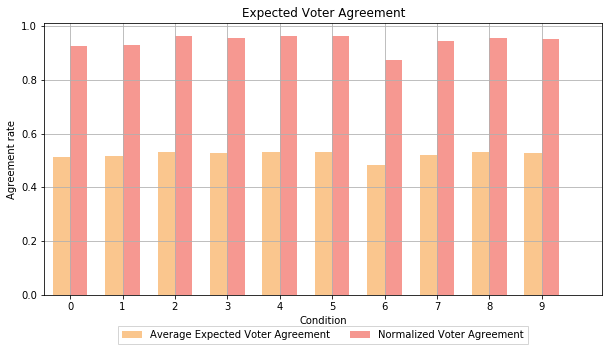

In [27]:
title = "Expected Voter Agreement"
xlabel = "Condition"
xticklabels = labels
ylabel = "Agreement rate"
legend = ["Average Expected Voter Agreement", "Normalized Voter Agreement", "X = 10"]
colours = ['#F78F1E', '#EE3224', '#FFC222']
name = "plot3_new"

data = pd.DataFrame([avg_expected_regrets, normalized_regrets]).T
plot_bar_chart_2(data, title, xlabel, xticklabels, ylabel, legend, colours, name)

In [8]:
def plot_bar_chart_3(df, title, xlabel, xticklabels, ylabel, legend, colours, name):
    pos = list(range(len(df[0])))
    width = 0.25

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10, 5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar(pos,
            # using df['pre_score'] data,
            df[0],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colours[0],
            # with label the first value in first_name
            label="before")

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width for p in pos],
            # using df['mid_score'] data,
            df[1],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colours[1],
            # with label the second value in first_name
            label="after")
    
    # Create a bar with post_score data,
    # in position pos + some width buffer,
    plt.bar([p + width*2 for p in pos],
        #using df['post_score'] data,
        df[2],
        # of width
        width,
        # with alpha 0.5
        alpha=0.5,
        # with color
        color=colours[2],
        # with label the third value in first_name
        label="nevermind")

    # Set the y axis label
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 0.5 * width for p in pos])

    # labels = ["{} bps".format(x) for x in range(10)]
    # Set the labels for the x ticks
    ax.set_xticklabels(xticklabels)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos) - width, max(pos) + width * 4)
    # plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])])

    # Adding the legend and showing the plot
    plt.legend(legend, loc='upper center',
               bbox_to_anchor=(0.5, -0.095),
               fancybox=False, shadow=False, ncol=5)
    plt.grid()
    plt.savefig(name, dpi=200)
    plt.show()

In [ ]:
# E = 0: no breaking points
# E = 1: one random breaking point for the first party
# E = 2: one breaking point on the top issue of the first party
# E = 3: two conflicting breaking points
# E = 4: one random breaking point per party
# E = 5: one top issue breaking point per party
# E = 6: two random breaking points per party
# E = 7: two top issue breaking points per party
# E = 8: one breaking point on the top issue of the first party + vote revaluation
# E = 9: one breaking point on a random issue of the last party
# E = 10: one breaking point on the top issue of the last party

for setting in settings:  
    grid_results = []
    X, I, N, C, poll_results = setting
    print("X = {}, N = {}, I = {}, C = {}".format(X, N, I, C))
    
    for i in range(10):             
        agendas = generate_agendas(I, X)
        profile = generate_relative_profile(N, agendas, poll_results)

        vote_results, vote_supporters = simulate_vote(agendas, profile, 1)
        median_voter = np.median(profile, axis=0)
        gold_regret = np.mean(calculate_regret(median_voter, profile, 1))

        supporters = divide_electorate(profile, agendas)
        keys = list(supporters.keys())
        keys.sort()
        no_supporters = [len(supporters[key]) for key in keys]
            
        for E in range(11):     

            if E == 0: 
                breaking_points = generate_breakingpoints(X, I, 0)
            elif E == 1 or E == 4 or E == 9: 
                breaking_points = generate_breakingpoints(X, I, 1)
            elif E == 2 or E == 8:                 
                breaking_points = derive_breaking_points(1, supporters, agendas, True)
            elif E == 3: 
                breaking_points = derive_breaking_points(2, supporters, agendas, True)
            elif E == 5 or E == 10:
                breaking_points = derive_breaking_points(1, supporters, agendas, False)
            elif E == 6:
                breaking_points = generate_breakingpoints(X, I, 2)
            elif E == 7: 
                breaking_points = derive_breaking_points(2, supporters, agendas, False)
                     
            if E == 1 or E == 2:
                breaking_points_one = [None] * X
                breaking_points_one[0] = breaking_points[0]
                breaking_points = breaking_points_one
                
            if E == 9 or E == 10:
                breaking_points_one = [None] * X
                breaking_points_one[-1] = breaking_points[-1]
                breaking_points = breaking_points_one
                
            if E == 8:
                vote_results = revaluate_votes(agendas, profile, vote_supporters, vote_results, breaking_points)

            possible_coalitions = generate_coalitions(vote_results, agendas, breaking_points)
            if len(possible_coalitions) == 0:
                grid_results.append([0, gold_regret, 0, 0])
                continue   

            expected_outcomes = simulate_outcomes(vote_results, possible_coalitions, agendas, breaking_points)
            ratings = rate_coalitions(possible_coalitions, agendas, vote_results, expected_outcomes, breaking_points)
            final_expected_outcomes = np.sum([expected_outcomes[c] * ratings[c] for c in range(len(possible_coalitions))], axis=0)   
            expected_regret = np.mean(calculate_regret(final_expected_outcomes, profile, 1))            
            
            entropy = calculate_entropy(final_expected_outcomes)
            grid_results.append([expected_regret, gold_regret, len(possible_coalitions), entropy])

            print(i, end='\r')

    filename = "model_runs/final/{}-{}-{}-{}.pickle".format(X, I, N, C)
    with open(filename, 'wb') as handle:
        pickle.dump(grid_results, handle, protocol=pickle.HIGHEST_PROTOCOL)
    print("saved.")

In [6]:
def plot_bar_chart_2(df, title, xlabel, xticklabels, ylabel, legend, colours, name):
    pos = list(range(len(df[0])))
    width = 0.33

    # Plotting the bars
    fig, ax = plt.subplots(figsize=(10, 5))

    # Create a bar with pre_score data,
    # in position pos,
    plt.bar(pos,
            # using df['pre_score'] data,
            df[0],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colours[0],
            # with label the first value in first_name
            label="before")

    # Create a bar with mid_score data,
    # in position pos + some width buffer,
    plt.bar([p + width for p in pos],
            # using df['mid_score'] data,
            df[1],
            # of width
            width,
            # with alpha 0.5
            alpha=0.5,
            # with color
            color=colours[1],
            # with label the second value in first_name
            label="after")

    # Set the y axis label
    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)

    # Set the chart's title
    ax.set_title(title)

    # Set the position of the x ticks
    ax.set_xticks([p + 0.5 * width for p in pos])

    # labels = ["{} bps".format(x) for x in range(10)]
    # Set the labels for the x ticks
    ax.set_xticklabels(xticklabels)

    # Setting the x-axis and y-axis limits
    plt.xlim(min(pos) - width, max(pos) + width * 4)
    # plt.ylim([0, max(df['pre_score'] + df['mid_score'] + df['post_score'])])

    # Adding the legend and showing the plot
    plt.legend(legend, loc='upper center',
               bbox_to_anchor=(0.5, -0.095),
               fancybox=False, shadow=False, ncol=5)
    plt.grid()
    plt.savefig(name, dpi=200)
    plt.show()